## ON THE INTERPRETATION OF LEARNING DYNAMICAL SYSTEMS

In [1]:
#---------------------------------------
# Load Libs
#---------------------------------------

import numpy as np
import scipy as sci
from matplotlib import pylab as plt
from matplotlib import cm

from sympy import Symbol, asin, sin
from scipy.special import ellipj, ellipk

import torch

In [2]:
#---------------------------------------
# Load utility functions
#---------------------------------------
from utils import *

In [5]:
#---------------------------------------
# Example 1: The Simple Harmonic Oscillator 
# Create Data
#---------------------------------------
anal_ts = np.linspace(0,10,1000)
Lambda = np.array(([0,1],[-1,0]))
x0 = np.array(([0,1]))
anal_thetas = solution_general_linear(Lambda=Lambda, x0=x0, ts=anal_ts)




Found a GPU


Text(0.5, 0, 'time')

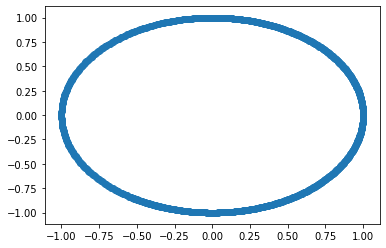

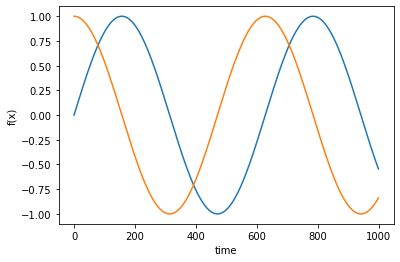

In [15]:
#---------------------------------------
# Plot Orbit and time series
#---------------------------------------
plt.figure()
plt.scatter(anal_thetas[:,0],anal_thetas[:,1])

plt.figure()
plt.plot(anal_thetas)
plt.ylabel('f(x)')
plt.xlabel('time')